In [1]:
!git clone https://github.com/MorningStarTM/Does-vision-pre-training-contribute-to-XAI.git

Cloning into 'Does-vision-pre-training-contribute-to-XAI'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 50 (delta 25), reused 37 (delta 20), pack-reused 0
Unpacking objects: 100% (50/50), 379.55 KiB | 4.17 MiB/s, done.


In [2]:
%cd Does-vision-pre-training-contribute-to-XAI

/kaggle/working/Does-vision-pre-training-contribute-to-XAI


In [3]:
!ls

LICENSE  README.md  models  notebook


In [4]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
import time
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from IPython import display
import matplotlib.gridspec as gridspec
from models import VggAutoencoder

2024-07-27 03:20:56.615045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 03:20:56.615158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 03:20:56.753937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
BATCH_SIZE = 32
EPOCHS = 10
H,W,C = 512,512,3
lr = 1e-5
latent_dim = 512

In [18]:
datagen = ImageDataGenerator(rescale=1./255)

train_batches = datagen.flow_from_directory(
    '/kaggle/input/dogs-vs-cats-train-validadion-and-evaluation/train',
    target_size=(H,W),
    batch_size=BATCH_SIZE,
    class_mode='input',  # Use 'input' mode for autoencoder training
    shuffle=True
)

Found 20000 images belonging to 2 classes.


In [19]:
test_batches = datagen.flow_from_directory(
    '/kaggle/input/cat-dog-images/dataset',
    target_size=(H,W),
    batch_size=BATCH_SIZE,
    class_mode='input',  # Use 'input' mode for autoencoder training
    shuffle=True
)

Found 2000 images belonging to 2 classes.


# Model

In [20]:
vae = VggAutoencoder((H,W,C))
model = vae.build_autoencoder()
model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_4 (Functional)       │ (None, 8, 8, 512)      │    31,449,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_5 (Functional)       │ (None, 512, 512, 3)    │    40,886,931 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,336,675 (275.94 MB)

 Trainable params: 72,336,675 (275.94 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

model.compile(optimizer=Adam(1e-5), loss=ssim_loss)

In [22]:
checkpoint_filepath = '/kaggle/working/vggpt_cat_dog.keras'
cbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
]

# Training

In [24]:
history = model.fit(train_batches, steps_per_epoch=50400  // BATCH_SIZE, epochs=25, callbacks=cbacks, validation_data=test_batches)

Epoch 1/25
   7/1575 ━━━━━━━━━━━━━━━━━━━━ 28:52 1s/step - loss: 0.2571

KeyboardInterrupt: 

In [25]:
batch_images, _ = next(test_batches)
predictions = model.predict(batch_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


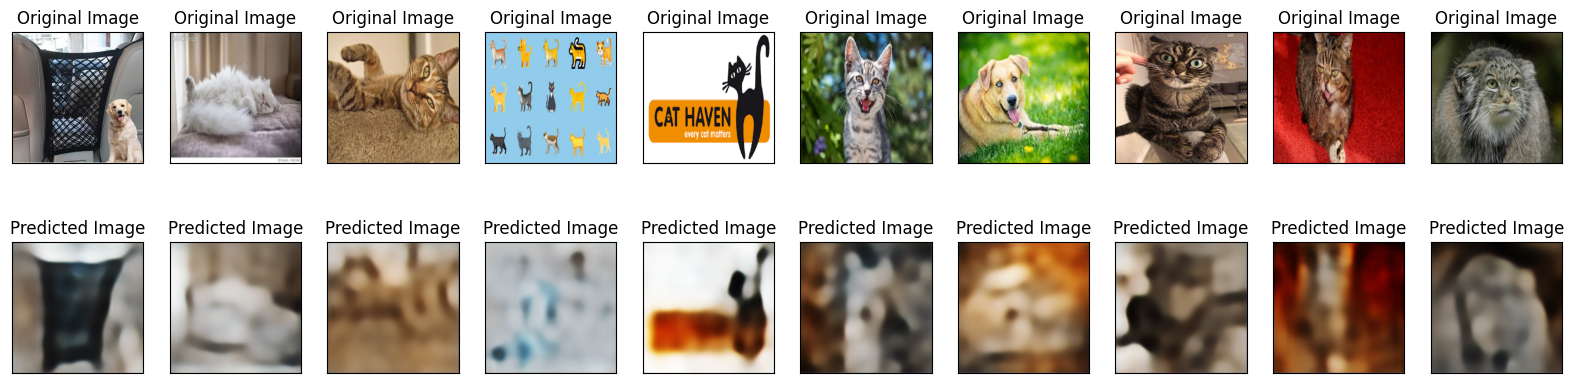

In [26]:
n = 10
plt.figure(figsize=(20,5))
for i in range(n):
    
    ax = plt.subplot(2, n, i+1)
    ax.set_title("Original Image")
    plt.imshow(batch_images[i].reshape(512, 512 ,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+1+n)
    ax.set_title("Predicted Image")
    plt.imshow(predictions[i].reshape(512, 512 ,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)